<a href="https://colab.research.google.com/github/JA4S/JANC/blob/main/examples/2D/Detonation-Tube(AMR)/2D_detonation_tube_amr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install JANC and import relevant libraries

In [ ]:
# Copyright © 2025 Haocheng Wen, Faxuan Luo
# SPDX-License-Identifier: MIT

!pip install git+https://github.com/JA4S/JANC.git
!wget https://raw.githubusercontent.com/JA4S/JANC/main/examples/2D/Detonation-Tube(AMR)/9sp-19r-H2-Air.yaml

In [ ]:
from janc_v2.model import thermo_model
from janc_v2.simulation import set_simulator
from jaxamr import amr
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'gpu')

# Set grid and AMR parameters

In [ ]:
Lx = 0.05
Ly = 0.0125

nx = 2000
ny = 500

dx = Lx/nx
dy = Ly/ny

base_grid = {'Lx':Lx,'Ly':Ly,'Nx':nx,'Ny':ny}

n_block = [
    [1, 1],  # Level 0
    [100, 25], # Level 1
    [2, 2],  # Level 2
    [2, 2],  # Level 3
    [2, 2]   # Level 4
    ] # x-direction, y-direction

template_node_num = 3

buffer_num = 5

refinement_tolerance = {
    'density': 1.4e4,
    'velocity': 1e4
}

amr_config = {'base_grid':base_grid,
        'n_block':n_block,
        'template_node_num':template_node_num,
        'buffer_num':buffer_num,
        'refinement_tolerance':refinement_tolerance
}

amr.set_amr(amr_config)

dx = [dx] # Grid size in refinement levels
dy = [dy]
for i, (bx, by) in enumerate(n_block[1:], 1):
    dx.append(Lx/nx / (2.0**i))
    dy.append(Ly/ny / (2.0**i))

# Set thermodynamics, reactions, and flux solver

In [ ]:
thermo_config = {'thermo_model':'nasa7',
         'mechanism_directory':'9sp-19r-H2-Air.yaml'
          }
thermo_model.set_thermo(thermo_config)
#reaction_config
reaction_config = {'is_detailed_chemistry':True,
           'mechanism_directory':'9sp-19r-H2-Air.yaml'
          }
#flux_config
flux_config = {'solver_type':'flux_splitting',
        'interface_reconstruction':'WENO5_JS',
        'split_method':'LF',
        'viscosity':'off'
        }

# Set boundary conditions

In [ ]:
boundary_config = {'left_boundary':'slip_wall',
           'right_boundary':'slip_wall',
           'bottom_boundary':'slip_wall',
           'top_boundary':'slip_wall'}

# Initializations

In [ ]:
time_control = {'temporal_evolution_scheme':'TVD_RK3'}
simulation_config = {'dimension':'2D',
            'thermo_config':thermo_config,
            'reaction_config':reaction_config,
            'flux_config':flux_config,
            'boundary_config':boundary_config,
            'time_config':time_control}
#call【AMR_Simulator】 instead of 【Simulator】(which is designed for regular grid)
advance_one_step, advance_one_step_L0 = set_simulator.AMR_Simulator(simulation_config)
#AMR_Simuator returns two time-stepping functions
#They both advance the block data one time step forward
#advance_one_step is used to advance the refinement level(level1,2,...)
#advance_one_step_L0 is used to advance the basic level(level0)

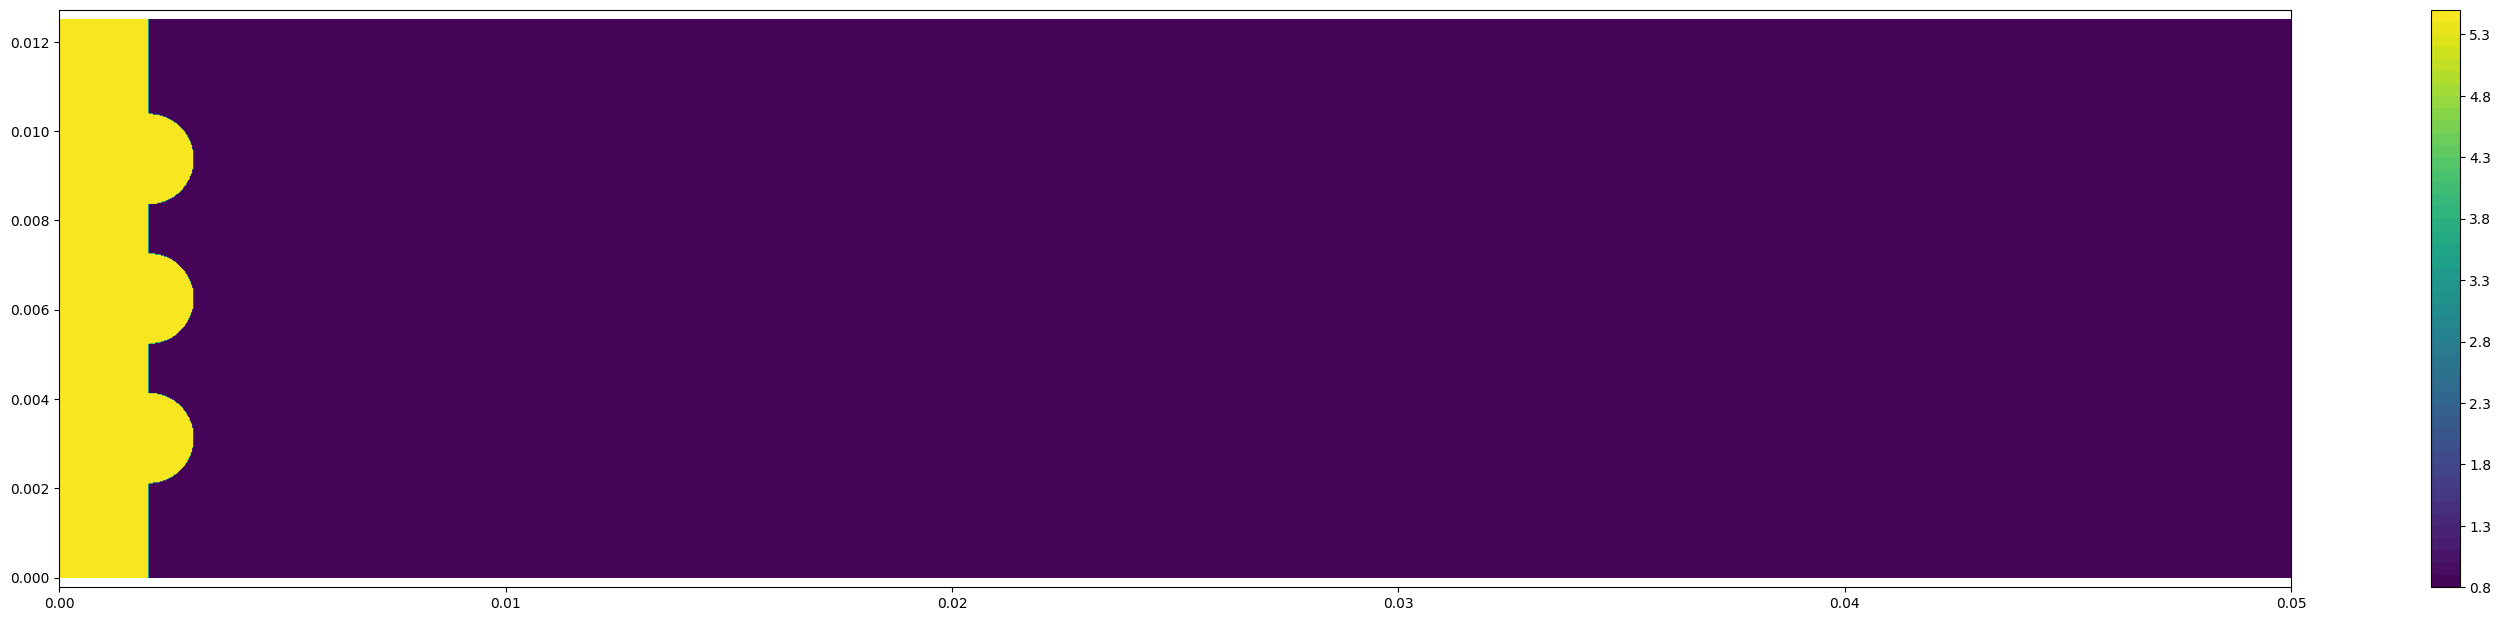

In [ ]:
def initial_conditions():
    #nondimensionalize the pressure and tempreature using P0,T0
    Penv = 1.0*101325; Tenv = 300; yH2env = 0.028; yO2env = 0.226;
    Pignition = 75*101325; Tignition = 3500;
    #set the mass fractions for the species (except inert species N2, which leaves 8 species to set)
    Yenv = jnp.array([yH2env,yO2env,0,0,0,0,0,0])

    #set ignition zone (rectangular shape)
    ignition_width = 80
    ignition_height = ny
    Y_init = jnp.broadcast_to(Yenv[:,None,None],(8,nx,ny))
    T_init = jnp.full((1,nx,ny),Tenv)
    T_init = T_init.at[:,0:ignition_width,0:ignition_height].set(Tignition)
    P_init = jnp.full((1,nx,ny),Penv)
    P_init = P_init.at[:,0:ignition_width,0:ignition_height].set(Pignition)
    #set ignition zone (circle shape)
    temp_x = jnp.linspace(0, nx, nx)
    temp_y = jnp.linspace(0, ny, ny)
    temp_x, temp_y = jnp.meshgrid(temp_y, temp_x)
    radius = ignition_width//2
    #three semicircle ignition zone to induce detonation cells
    distance_1 = jnp.sqrt((temp_y[None,:,:] - ignition_width)**2 + (temp_x[None,:,:] - ignition_height//4)**2)
    distance_2 = jnp.sqrt((temp_y[None,:,:] - ignition_width)**2 + (temp_x[None,:,:] - (ignition_height//4)*2)**2)
    distance_3 = jnp.sqrt((temp_y[None,:,:] - ignition_width)**2 + (temp_x[None,:,:] - (ignition_height//4)*3)**2)
    mask = (distance_1 <= radius) | (distance_2 <= radius) | (distance_3 <= radius)
    T_init = T_init.at[mask].set(Tignition)
    P_init = P_init.at[mask].set(Pignition)

    #get relevant thermo properties from tempreature and species mass fractions
    _,gamma_init,h_init,R_init,_ = thermo_model.get_thermo(T_init,Y_init)

    rho_init = P_init/(R_init*T_init)
    E_init = rho_init*h_init - P_init
    rhou_init = jnp.zeros((1,nx,ny))
    rhov_init = jnp.zeros((1,nx,ny))

    #concatenate the conservative variables U, and thermo variables aux(gamma,T)
    U_init = jnp.concatenate([rho_init,rhou_init,rhov_init,E_init,rho_init*Y_init],axis=0)
    aux_init = jnp.concatenate([gamma_init,T_init],axis=0)
    return U_init, aux_init


U, aux = initial_conditions()
plt.figure(figsize=(36, 7.5))
x = jnp.linspace(0, Lx, nx)
y = jnp.linspace(0, Ly, ny)
X, Y = jnp.meshgrid(x, y, indexing='ij')
plt.contourf(X, Y, U[0], levels=50, cmap='viridis')
plt.colorbar()
plt.axis('equal')


blk_data0 = jnp.concatenate([U,aux],axis=0)[None,:,:,:]

blk_info0 = {
  'number': 1,
  'index': jnp.array([0, 0]),
  'glob_index': jnp.array([[0, 0]]),
  'neighbor_index': jnp.array([[-1, -1, -1, -1]])}

# AMR Loop

In [ ]:
dt = 1e-9  # time step

nt = 200 # computation steps

amr_update_step = 5 # AMR update steps

amr_initialized = False

for step in tqdm(range(nt), desc="Progress", unit="step"):

    if amr_initialized == False :

        blk_data1, blk_info1, max_blk_num1 = amr.initialize(1, blk_data0, blk_info0, 'density', dx[1], dy[1])
        blk_data2, blk_info2, max_blk_num2 = amr.initialize(2, blk_data1, blk_info1, 'density', dx[2], dy[2])
        blk_data3, blk_info3, max_blk_num3 = amr.initialize(3, blk_data2, blk_info2, 'density', dx[3], dy[3])

        amr_initialized = True

    elif (step % amr_update_step == 0):
        blk_data1, blk_info1, max_blk_num1 = amr.update(1, blk_data0, blk_info0, 'density', dx[1], dy[1], blk_data1, blk_info1, max_blk_num1)
        blk_data2, blk_info2, max_blk_num2 = amr.update(2, blk_data1, blk_info1, 'density', dx[2], dy[2], blk_data2, blk_info2, max_blk_num2)
        blk_data3, blk_info3, max_blk_num3 = amr.update(3, blk_data2, blk_info2, 'density', dx[3], dy[3], blk_data3, blk_info3, max_blk_num3)


    '''Crossover advance'''
    for _ in range(2):
        for _ in range(2):
            for _ in range(2):
                blk_data3 = advance_one_step(3, blk_data2, dx[3], dy[3], dt/8.0, blk_data3, blk_info3)
            blk_data2 = advance_one_step(2, blk_data1, dx[2], dy[2], dt/4.0, blk_data2, blk_info2)
        blk_data1 = advance_one_step(1, blk_data0, dx[1], dy[1], dt/2.0, blk_data1, blk_info1)
    blk_data0 = advance_one_step_L0(blk_data0, dx[0], dy[0], dt)


    '''Synchronous advance'''
    #blk_data3 = solver.rk2(3, blk_data2, dx[3], dy[3], dt/8.0, blk_data3, blk_info3)
    #blk_data2 = solver.rk2(2, blk_data1, dx[2], dy[2], dt/8.0, blk_data2, blk_info2)
    #blk_data1 = solver.rk2(1, blk_data0, dx[1], dy[1], dt/8.0, blk_data1, blk_info1)
    #blk_data0 = solver.rk2_L0(blk_data0, dx[0], dy[0], dt/8.0)

    blk_data2 = amr.interpolate_fine_to_coarse(3, blk_data2, blk_data3, blk_info3)
    blk_data1 = amr.interpolate_fine_to_coarse(2, blk_data1, blk_data2, blk_info2)
    blk_data0 = amr.interpolate_fine_to_coarse(1, blk_data0, blk_data1, blk_info1)


Progress:   0%|          | 0/200 [00:00<?, ?step/s]


AMR Initialized at Level [1] with [70] blocks

AMR Initialized at Level [2] with [130] blocks

AMR Initialized at Level [3] with [280] blocks


Progress:   2%|▎         | 5/200 [00:56<16:20,  5.03s/step]


AMR Updated at Level [1] with [60/70] blocks [valid/max]

AMR Updated at Level [2] with [116/130] blocks [valid/max]

AMR Updated at Level [3] with [244/280] blocks [valid/max]


Progress:   5%|▌         | 10/200 [01:01<04:05,  1.29s/step]


AMR Updated at Level [1] with [62/70] blocks [valid/max]

AMR Updated at Level [2] with [122/130] blocks [valid/max]

AMR Updated at Level [3] with [256/280] blocks [valid/max]


Progress:   8%|▊         | 15/200 [01:03<01:29,  2.08step/s]


AMR Updated at Level [1] with [62/70] blocks [valid/max]

AMR Updated at Level [2] with [122/130] blocks [valid/max]

AMR Updated at Level [3] with [265/280] blocks [valid/max]


Progress:  10%|█         | 20/200 [01:06<01:11,  2.50step/s]


AMR Updated at Level [1] with [62/70] blocks [valid/max]

AMR Updated at Level [2] with [124/130] blocks [valid/max]

AMR Updated at Level [3] with [271/280] blocks [valid/max]


Progress:  12%|█▎        | 25/200 [01:08<00:58,  3.00step/s]


AMR Updated at Level [1] with [62/70] blocks [valid/max]

AMR Updated at Level [2] with [124/130] blocks [valid/max]

AMR max_blk_num Updated as[ 560 ] at Level [ 3 ]

AMR Updated at Level [3] with [286/560] blocks [valid/max]


Progress:  15%|█▌        | 30/200 [01:26<04:33,  1.61s/step]


AMR Updated at Level [1] with [62/70] blocks [valid/max]

AMR Updated at Level [2] with [128/130] blocks [valid/max]

AMR Updated at Level [3] with [292/560] blocks [valid/max]


Progress:  18%|█▊        | 35/200 [01:30<02:03,  1.34step/s]


AMR Updated at Level [1] with [63/70] blocks [valid/max]

AMR Updated at Level [2] with [128/130] blocks [valid/max]

AMR Updated at Level [3] with [296/560] blocks [valid/max]


Progress:  20%|██        | 40/200 [01:33<01:33,  1.72step/s]


AMR Updated at Level [1] with [64/70] blocks [valid/max]

AMR max_blk_num Updated as[ 260 ] at Level [ 2 ]

AMR Updated at Level [2] with [131/260] blocks [valid/max]

AMR Updated at Level [3] with [298/560] blocks [valid/max]


Progress:  22%|██▎       | 45/200 [02:07<07:21,  2.85s/step]


AMR Updated at Level [1] with [64/70] blocks [valid/max]

AMR Updated at Level [2] with [134/260] blocks [valid/max]

AMR Updated at Level [3] with [298/560] blocks [valid/max]


Progress:  25%|██▌       | 50/200 [02:12<02:39,  1.06s/step]


AMR Updated at Level [1] with [64/70] blocks [valid/max]

AMR Updated at Level [2] with [136/260] blocks [valid/max]

AMR Updated at Level [3] with [309/560] blocks [valid/max]


Progress:  27%|██▋       | 54/200 [02:15<06:05,  2.51s/step]


KeyboardInterrupt: 

#Visulization

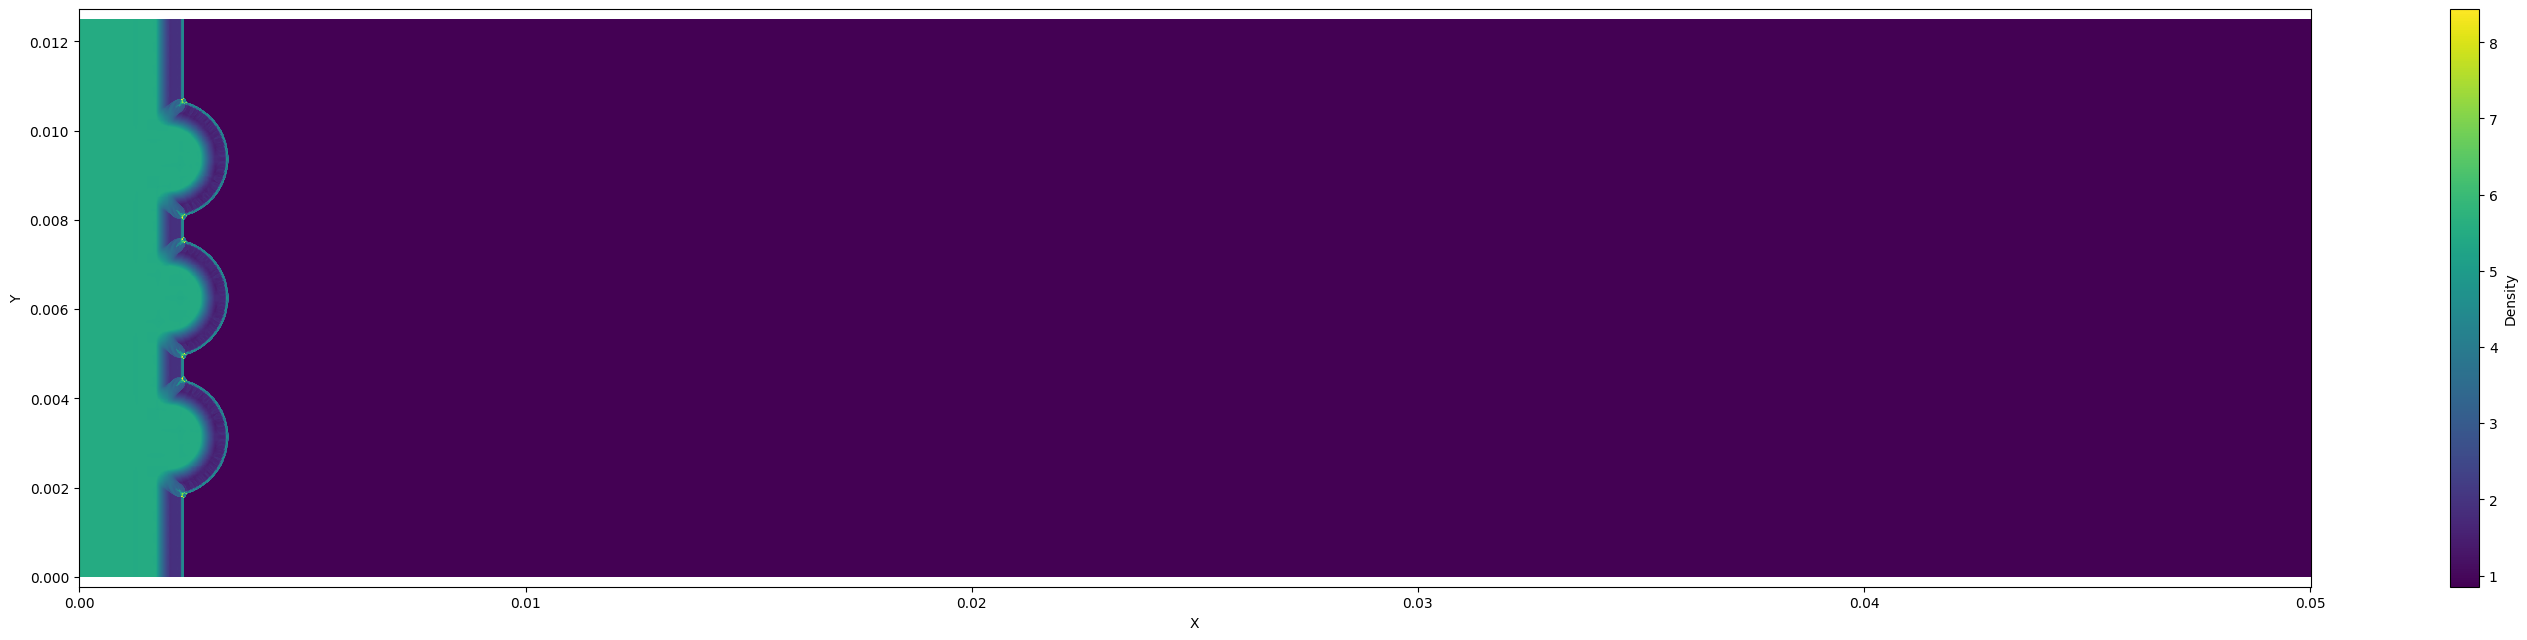

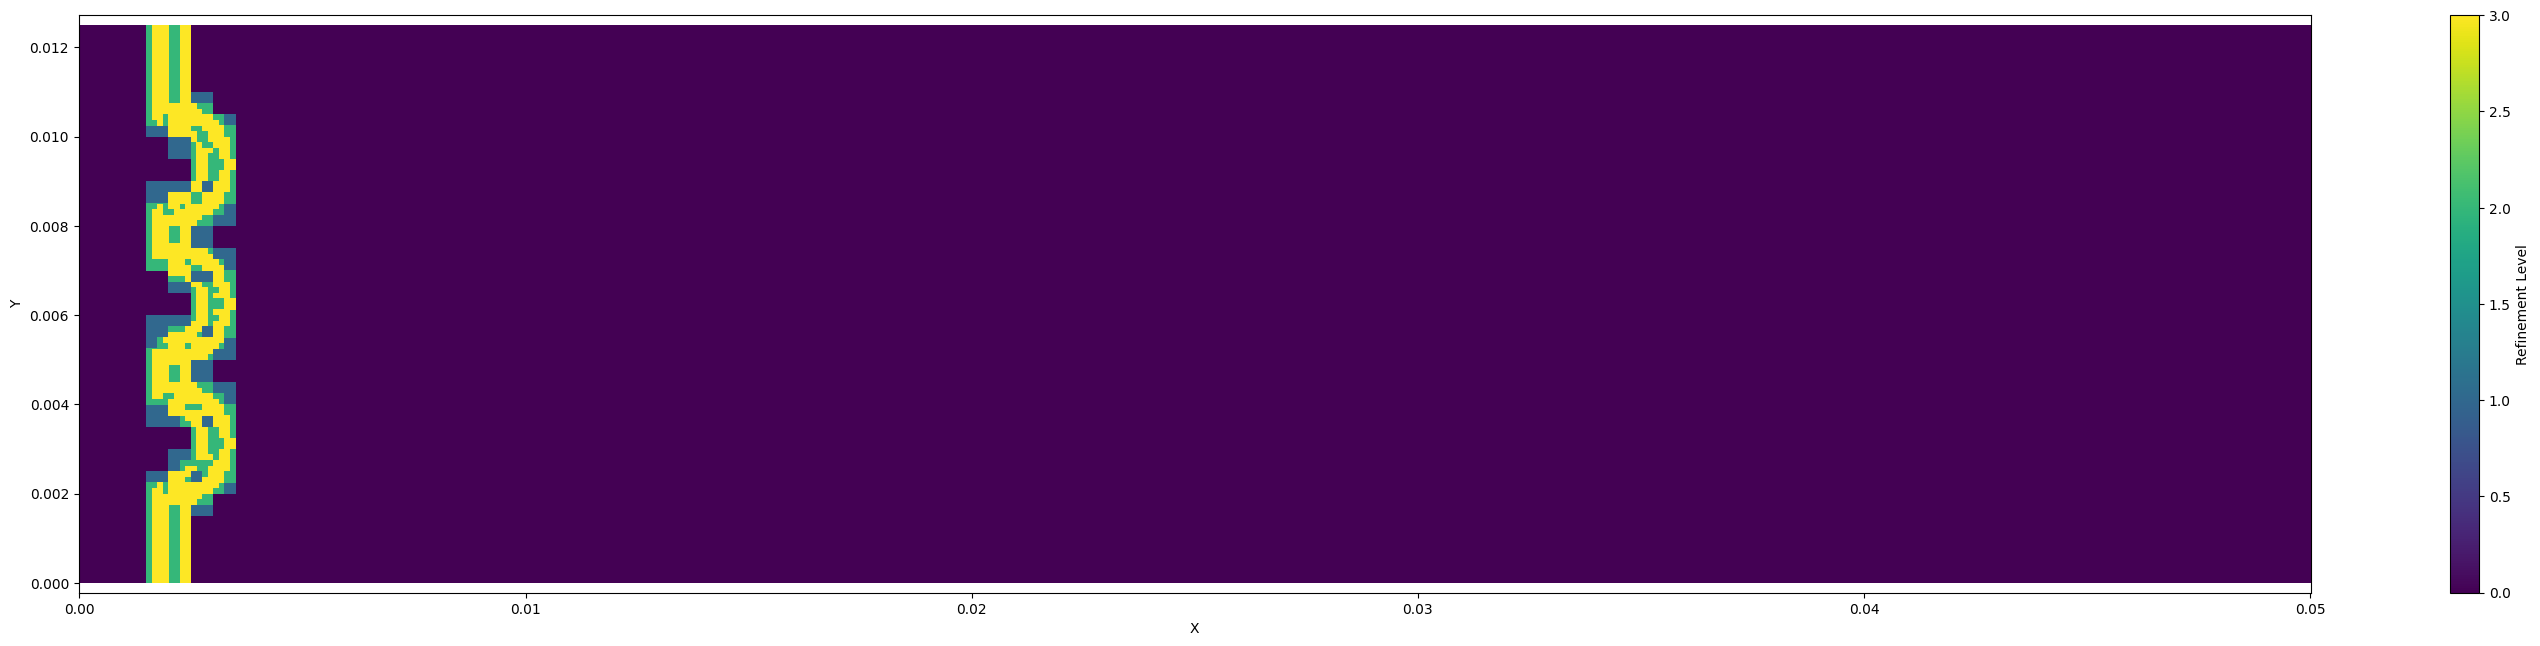

In [ ]:
# Density Contour
plt.figure(figsize=(36, 7.5))
ax = plt.gca()
from jaxamr import amraux
component = 0
vmin = jnp.min(blk_data0[:, component])
vmax = jnp.max(blk_data0[:, component])
vrange = (vmin, vmax)
fig = amraux.plot_block_data(blk_data0[:, component], blk_info0, ax, vrange) # Level 0
fig = amraux.plot_block_data(blk_data1[:, component], blk_info1, ax, vrange) # Level 1
fig = amraux.plot_block_data(blk_data2[:, component], blk_info2, ax, vrange) # Level 2
fig = amraux.plot_block_data(blk_data3[:, component], blk_info3, ax, vrange) # Level 3

plt.colorbar(fig, ax=ax, label='Density')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.axis('equal')
plt.show()


# AMR Level Contour
plt.figure(figsize=(36, 7.5))
ax = plt.gca()
from jaxamr import amraux
component = 0
vmin = jnp.min(blk_data0[:, component])
vmax = jnp.max(blk_data0[:, component])
vrange = (0, 3)
fig = amraux.plot_block_data(0*jnp.ones_like(blk_data0[:, component]), blk_info0, ax, vrange) # Level 0
fig = amraux.plot_block_data(1*jnp.ones_like(blk_data1[:, component]), blk_info1, ax, vrange) # Level 1
fig = amraux.plot_block_data(2*jnp.ones_like(blk_data2[:, component]), blk_info2, ax, vrange) # Level 2
fig = amraux.plot_block_data(3*jnp.ones_like(blk_data3[:, component]), blk_info3, ax, vrange) # Level 3

plt.colorbar(fig, ax=ax, label='Refinement Level')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.axis('equal')
plt.show()